In [1]:
# Import packages
import json
import tensorflow as tf
import csv
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:
# Parameters
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1
corpus = []

In [3]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

--2019-10-26 17:35:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
R'esolution de storage.googleapis.com (storage.googleapis.com)... 74.125.193.128
Connexion `a storage.googleapis.com (storage.googleapis.com)|74.125.193.128|:443... connect'e.
requ^ete HTTP transmise, en attente de la r'eponse... 200 OK
Taille : 238942690 (228M) [application/octet-stream]
Sauvegarde en : << /tmp/training_cleaned.csv >>

/tmp/training_clean 100%[===================>] 227.87M   759KB/s    ds 3m 26s  

2019-10-26 17:39:14 (1.11 MB/s) - << /tmp/training_cleaned.csv >> sauvegard'e [238942690/238942690]



In [46]:
print('num_sentences:', num_sentences)
print('len(corpus):', len(corpus))
print('corpus[214]:', corpus[214])

num_sentences: 1600000
len(corpus): 1600000
corpus[214]: ['@InezLeb euwww i am so ugly in the picture ', 0]


In [47]:
# Separate sentences and labels
sentences = []
labels = []
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

In [48]:
# Preprocess inputs

# Define the tokenizer
tokenizer = Tokenizer()
# Fit on the sentences (= inputs)
tokenizer.fit_on_texts(sentences)
# Define the word_index vocabulary
word_index = tokenizer.word_index
# Get the size of the dictionary
vocab_size = len(word_index)

In [49]:
# Transform the sentences in sequences
sequences = tokenizer.texts_to_sequences(sentences)
# Pad the sequences
padded = pad_sequences(sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

In [50]:
# Split training and testing
split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [51]:
print("vocab_size:", vocab_size)
print("word_index['i']:", word_index['i'])

vocab_size: 138054
word_index['i']: 1


In [13]:
# Download the GloVe models (= Word2Vec models)
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2019-10-26 17:48:44--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
R'esolution de storage.googleapis.com (storage.googleapis.com)... 172.217.17.80
Connexion `a storage.googleapis.com (storage.googleapis.com)|172.217.17.80|:443... connect'e.
requ^ete HTTP transmise, en attente de la r'eponse... 200 OK
Taille : 347116733 (331M) [text/plain]
Sauvegarde en : << /tmp/glove.6B.100d.txt >>

/tmp/glove.6B.100d. 100%[===================>] 331.04M   691KB/s    ds 10m 6s  

2019-10-26 17:58:52 (559 KB/s) - << /tmp/glove.6B.100d.txt >> sauvegard'e [347116733/347116733]



In [52]:
# Get the coefficients from the matrix
temp = 0
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype = 'float32');
        embeddings_index[word] = coefs;
        if temp == 100:
            print('line')
            print(line)
            print('values')
            print(values)
            print('word')
            print(word)
            print('coefs')
            print(coefs)
            print('\n')
        temp = temp + 1

line
so -0.39551 0.5466 0.50315 -0.63682 -0.4547 0.30889 -0.04924 0.27191 0.31562 -0.32879 0.25089 0.14508 0.35136 -0.22793 -0.15894 -0.51527 -0.27978 0.3647 -0.39425 0.33299 0.43051 0.183 0.25095 -0.18547 0.34698 0.055137 -0.45979 -0.82963 -0.018523 -0.36772 0.045566 0.71052 -0.022782 -0.080889 0.20685 0.49855 -0.059794 -0.0080048 -0.23823 -0.33759 -0.24201 -0.23788 -0.0011362 -0.40395 -0.44859 -0.32189 0.48405 -0.027999 0.10148 -0.93585 -0.087522 -0.39959 0.36545 1.3726 -0.30713 -2.594 0.22431 -0.041168 1.7765 0.4001 -0.10996 1.4178 -0.26154 0.18617 0.79328 -0.11709 0.87541 0.43911 0.34711 -0.28515 0.076269 -0.63038 0.16408 -0.37053 0.58485 -0.15472 -0.26382 -0.1859 -0.75228 -0.15752 0.78539 -0.018846 -0.8013 0.15561 -1.8624 -0.16969 0.19419 -0.30683 -0.78067 -0.49689 -0.18256 -0.042016 -0.2629 0.058531 -0.44664 -0.099765 -0.4305 -0.23693 -0.014519 0.31981

values
['so', '-0.39551', '0.5466', '0.50315', '-0.63682', '-0.4547', '0.30889', '-0.04924', '0.27191', '0.31562', '-0.32879', '

In [53]:
# Print the embeddings_index
print(len(embeddings_index))
print(embeddings_index['so'])

400000
[-3.9551e-01  5.4660e-01  5.0315e-01 -6.3682e-01 -4.5470e-01  3.0889e-01
 -4.9240e-02  2.7191e-01  3.1562e-01 -3.2879e-01  2.5089e-01  1.4508e-01
  3.5136e-01 -2.2793e-01 -1.5894e-01 -5.1527e-01 -2.7978e-01  3.6470e-01
 -3.9425e-01  3.3299e-01  4.3051e-01  1.8300e-01  2.5095e-01 -1.8547e-01
  3.4698e-01  5.5137e-02 -4.5979e-01 -8.2963e-01 -1.8523e-02 -3.6772e-01
  4.5566e-02  7.1052e-01 -2.2782e-02 -8.0889e-02  2.0685e-01  4.9855e-01
 -5.9794e-02 -8.0048e-03 -2.3823e-01 -3.3759e-01 -2.4201e-01 -2.3788e-01
 -1.1362e-03 -4.0395e-01 -4.4859e-01 -3.2189e-01  4.8405e-01 -2.7999e-02
  1.0148e-01 -9.3585e-01 -8.7522e-02 -3.9959e-01  3.6545e-01  1.3726e+00
 -3.0713e-01 -2.5940e+00  2.2431e-01 -4.1168e-02  1.7765e+00  4.0010e-01
 -1.0996e-01  1.4178e+00 -2.6154e-01  1.8617e-01  7.9328e-01 -1.1709e-01
  8.7541e-01  4.3911e-01  3.4711e-01 -2.8515e-01  7.6269e-02 -6.3038e-01
  1.6408e-01 -3.7053e-01  5.8485e-01 -1.5472e-01 -2.6382e-01 -1.8590e-01
 -7.5228e-01 -1.5752e-01  7.8539e-01 -1.8846

In [54]:
# Initialize an embedding matrix of shape = (vocab_size + 1, embedding_dim)
embeddings_matrix = np.zeros((vocab_size + 1, embedding_dim));

# For every word in the dictionary
for word, i in word_index.items():
    # Get the embedding vector of the word
    embedding_vector = embeddings_index.get(word);
    # If the word is in the vocabulary
    if embedding_vector is not None:
        # Add the row of its indice in the embedding matrix
        # While keeping the index 'i', the indices in the embeddings matrix and the dictionary is the same for the same word
        embeddings_matrix[i] = embedding_vector;

In [55]:
# Print the embeddings_matrix
print('number of words embedded:', len(embeddings_matrix))
print('shape of an embedded word:', len(embeddings_matrix[0]))

number of words embedded: 138055
shape of an embedded word: 100


In [56]:
# Verify
assert len(embeddings_matrix) == vocab_size + 1

In [57]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, 
                              embedding_dim, 
                              input_length = max_length, 
                              weights = [embeddings_matrix], 
                              trainable = False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation = 'relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           13805500  
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 13,870,653
Trainable params: 65,153
Non-trainable params: 13,805,500
_____________________________________

In [59]:
print(type(training_sequences))
training_labels = np.asarray(training_labels)
training_labels = training_labels.reshape([training_labels.shape[0], 1])
print(type(training_labels))

print(type(test_sequences))
test_labels = np.asarray(test_labels)
test_labels = test_labels.reshape([test_labels.shape[0], 1])
print(type(test_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>


In [60]:
print(training_sequences.shape, training_labels.shape)
print(test_sequences.shape, test_labels.shape)

(144000, 16) (144000, 1)
(16000, 16) (16000, 1)


In [61]:
# Training
num_epochs = 10
history = model.fit(training_sequences, 
                    training_labels, 
                    epochs = num_epochs, 
                    validation_data = (test_sequences, test_labels))

print("Training Complete")

Train on 144000 samples, validate on 16000 samples
Epoch 1/10
144000/144000 [==============================] - 124s 861us/sample - loss: 0.5669 - accuracy: 0.6999 - val_loss: 0.5234 - val_accuracy: 0.7380
Epoch 2/10
144000/144000 [==============================] - 117s 812us/sample - loss: 0.5283 - accuracy: 0.7317 - val_loss: 0.5112 - val_accuracy: 0.7450
Epoch 3/10
144000/144000 [==============================] - 113s 786us/sample - loss: 0.5112 - accuracy: 0.7437 - val_loss: 0.5035 - val_accuracy: 0.7492
Epoch 4/10
144000/144000 [==============================] - 113s 783us/sample - loss: 0.4998 - accuracy: 0.7512 - val_loss: 0.5007 - val_accuracy: 0.7516
Epoch 5/10
144000/144000 [==============================] - 116s 806us/sample - loss: 0.4913 - accuracy: 0.7577 - val_loss: 0.4973 - val_accuracy: 0.7513
Epoch 6/10
144000/144000 [==============================] - 103s 716us/sample - loss: 0.4839 - accuracy: 0.7619 - val_loss: 0.5000 - val_accuracy: 0.7541
Epoch 7/10
144000/144000 

<Figure size 432x288 with 0 Axes>

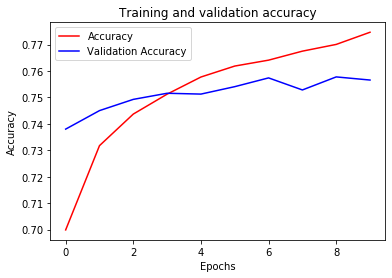

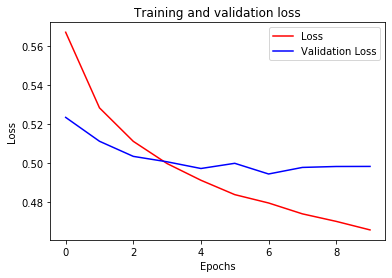

<Figure size 432x288 with 0 Axes>

In [64]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!